<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/evaluate_fer_sai_raw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task evaluation

#### Loading Models
Please note the models output `task,domain,feature`

In [1]:
# ! pip install pandas

In [2]:
# ! pip install opendatasets

In [3]:
!git clone https://github.com/scaairesearch/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 242 (delta 14), reused 0 (delta 0), pack-reused 209
Receiving objects: 100% (242/242), 11.77 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [4]:
!pip install -q -r requirements.txt # -q is for quiet install
!pip install -q opendatasets # quient install, for some reason this does not get installed with requirements

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install facenet_pytorch

  Using cached facenet_pytorch-2.5.3-py3-none-any.whl (1.9 MB)


In [6]:
from pathlib import Path
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.utils import show_batch
from da_cv_fer.model_DANN import DANN
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import (weights_init,
                             train_model,
                             get_correct_predictions,
                             test_model)

import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import tarfile
import cv2
import time
import os
import math
from datetime import datetime

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [8]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Loading Models to evaluate

In [9]:
dataconfig_inference=DataConfig()

In [10]:
NON_DANN_SFEW_EXPW_DIR = "/content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw"

In [11]:
non_dann_model_sfew_expw_name = 'non_dann_sfew_expw_04_02.pt'#'non_dann_sfew_expw_31_01.pt'#
dann_model_sfew_expw_name ='dann_sfew_expw_04_02.pt' #'dann_sfew_expw_31_01.pt' #
ewc_dann_model_sfew_expw_name = 'ewc_dann_sfew_expw_04_02.pt' #'ewc_dann_sfew_expw_31_01.pt' #

In [35]:
# NON DANN
non_dann_model_inference = DANN(num_classes=7,backbone='resnet18', dropout=0.1) # skeleton copy
NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

try:
    non_dann_model_inference.load_state_dict(torch.load(Path(NON_DANN_SFEW_EXPW_DIR, non_dann_model_sfew_expw_name),
                                                        map_location=torch.device(device)))
    print(f'{non_dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {non_dann_model_sfew_expw_name}')

# DANN
dann_model_sfew_expw_inference = DANN(num_classes=7,backbone='resnet18', dropout=0.1) # skeleton copy
DANN_SFEW_EXPW_DIR = dataconfig_inference.DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"dann_sfew_expw")
try:
    dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(DANN_SFEW_EXPW_DIR, dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {dann_model_sfew_expw_name}')

# EWC DANN
ewc_dann_model_sfew_expw_inference = DANN(num_classes=7,backbone='resnet18', dropout=0.1) # skeleton copy
EWC_DANN_SFEW_EXPW_DIR = dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"ewc_dann_sfew_expw")
print(dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR)
try:
    ewc_dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(EWC_DANN_SFEW_EXPW_DIR, ewc_dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{ewc_dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {ewc_dann_model_sfew_expw_name}')


feature extractor backbone created using resnet18 model
non_dann_sfew_expw_04_02.pt locked and loaded
feature extractor backbone created using resnet18 model
dann_sfew_expw_04_02.pt locked and loaded
feature extractor backbone created using resnet18 model
/content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw
ewc_dann_sfew_expw_04_02.pt locked and loaded


### Dataloaders for source and target

In [36]:
# sfew = DatasetSFEW()
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew already exists.
Files exist in dataset/sfew, extraction not done
Unzipped Files already exist in dataset/sfew, not extracted
Unzipped Files already exist in dataset/sfew/Train, not extracted
Unzipped Files already exist in dataset/sfew/Val, not extracted
----------mean_ds = [0.2197, 0.1858, 0.1569], std_dev_ds = [0.181, 0.1635, 0.1511]----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
expw_obj = EXPWCROP()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds already exists.
Unzipped Files already exist in dataset/expwds, not extracted


In [38]:
len(sfew_train_loader.dataset)

913

In [27]:
len(sfew_val_loader.dataset)

419

In [29]:
len(expw_train_loader.dataset)

646

In [28]:
len(expw_val_loader.dataset)

34

In [39]:
#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

def test_model(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output, _ , _  = model(images) # forward pass, output = {class, domain, feature}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy

#### Printing comparison

### SFEW evaluated on SFEW val loader


In [44]:
runconfig = RunConfig()
_, _, non_dann_accuracy_source_sfew = test_model(model= non_dann_model_inference.to(device),
                                 device=device,
                                 data_loader=sfew_val_loader,
                                 class_loss_function=runconfig.criterion_class )

_,_,dann_accuracy_source_sfew = test_model(model =dann_model_sfew_expw_inference.to(device),
                                 device=device,
                                 data_loader=sfew_val_loader,
                                 class_loss_function=runconfig.criterion_class )

_,_,ewc_dann_accuracy_source_sfew = test_model(model =ewc_dann_model_sfew_expw_inference.to(device),
                                 device=device,
                                 data_loader=sfew_val_loader,
                                 class_loss_function=runconfig.criterion_class )

Test / Val: Average loss: 0.1568, Accuracy: 196/419 (46.78%)

Test / Val: Average loss: 0.1552, Accuracy: 196/419 (46.78%)

Test / Val: Average loss: 0.1582, Accuracy: 196/419 (46.78%)



### EXPW evaluated on EXPW Val loader


In [43]:
_,_,non_dann_accuracy_source = test_model(model =non_dann_model_inference,
                                 device=device,
                                 data_loader=expw_val_loader,
                                 class_loss_function=runconfig.criterion_class )

_,_,dann_accuracy_target = test_model(model =dann_model_sfew_expw_inference,
                                 device=device,
                                 data_loader=expw_val_loader,
                                 class_loss_function=runconfig.criterion_class )

_,_,ewc_dann_accuracy_target = test_model(model =ewc_dann_model_sfew_expw_inference,
                                 device=device,
                                 data_loader=expw_val_loader,
                                 class_loss_function=runconfig.criterion_class )

Test / Val: Average loss: 0.5810, Accuracy: 2/34 (5.88%)

Test / Val: Average loss: 0.7050, Accuracy: 2/34 (5.88%)

Test / Val: Average loss: 0.5937, Accuracy: 2/34 (5.88%)



### Task Accuracy Result Table

In [45]:
task_accuracy_d = {'SFEW': pd.Series([non_dann_accuracy_source_sfew, dann_accuracy_source_sfew, ewc_dann_accuracy_source_sfew],
                      index=['non_dann', 'dann', 'dann_ewc']),
     'EXPW': pd.Series([non_dann_accuracy_source, dann_accuracy_target, ewc_dann_accuracy_target],
                      index=['non_dann', 'dann', 'dann_ewc'])}

task_accuracy_df = pd.DataFrame(task_accuracy_d)

In [46]:
task_accuracy_df

,SFEW,EXPW
non_dann,46.778043,5.882353
dann,46.778043,5.882353
dann_ewc,46.778043,5.882353


In [47]:
task_accuracy_df.to_csv('/content/gdrive/MyDrive/CV_FER/results/taskacc_nonrace_{}.csv'.format(datetime.now().strftime("%d-%m-%Y_%H:%M")))

### Evaluating EXPW Race test

In [48]:
#function to extract dataset
from zipfile import ZipFile

In [49]:
#define paths for extraction

dataconfig = DataConfig()
EXPW_RACEDS_BASE_PATH = "/content/gdrive/MyDrive/CV_FER/dataset"
EXPW_RACEDS_EXTRACT_PATH = "/content/gdrive/MyDrive/CV_FER/dataset/RaceTest_EXPW"
EXPW_RACEDS_ZIP_FILE_PATH = "/content/gdrive/MyDrive/CV_FER/dataset"
EXPW_RACEDS_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

labels_map={"0":"Angry",
"1":"Disgust",
"2":"Fear",
"3":"Happy",
"4":"Sad",
"5":"Surprise",
"6":"Neutral"}

labels_map2={"Angry":"0",
"Disgust": "1",
"Fear":"2",
"Happy":"3",
"Sad":"4",
"Surprise":"5",
"Neutral":"6"}

labels=list(labels_map.values())

EXPW_RACEDS_dict_dataset = {'TEST_DIR' : EXPW_RACEDS_EXTRACT_PATH}

print(f'self.BASE_PATH -{EXPW_RACEDS_BASE_PATH } | self.EXTRACT_DIR- {EXPW_RACEDS_EXTRACT_PATH} | self.ZIP_FILE_PATH - {EXPW_RACEDS_ZIP_FILE_PATH} ')

self.BASE_PATH -/content/gdrive/MyDrive/CV_FER/dataset | self.EXTRACT_DIR- /content/gdrive/MyDrive/CV_FER/dataset/RaceTest_EXPW | self.ZIP_FILE_PATH - /content/gdrive/MyDrive/CV_FER/dataset 


In [50]:
#extract data EXPW
if not (os.path.exists(EXPW_RACEDS_EXTRACT_PATH+"/"+"EXPW_annotated")):
  try:
      with ZipFile(Path(EXPW_RACEDS_ZIP_FILE_PATH, "EXPW_annotated.zip"), 'r') as zip:
          zip.extractall(Path(EXPW_RACEDS_EXTRACT_PATH))
          print("Done")
  except Exception as e:
      print('Failed: ', e)

In [51]:
data_list=[]
EXPW_RACEDS_IM_PATH=EXPW_RACEDS_EXTRACT_PATH+ "/EXPW_annotated"
EXPW_RACEDS_list=os.listdir(EXPW_RACEDS_IM_PATH)
EXPW_RACEDS_dict={}
EXPW_RACEDS_dict_list=[]
for i in EXPW_RACEDS_list:
    race = os.listdir(EXPW_RACEDS_IM_PATH+"/"+i)
    EXPW_RACEDS_dict[i] = {key: None for key in race}

for emotion in EXPW_RACEDS_list:
    for race in EXPW_RACEDS_dict[emotion]:
        EXPW_RACEDS_dict[emotion][race]=os.listdir(EXPW_RACEDS_IM_PATH+"/"+emotion+"/"+race)
        EXPW_RACEDS_dict_list+=[[emotion, race, i] for i in os.listdir(EXPW_RACEDS_IM_PATH+"/"+emotion+"/"+race)]

In [52]:
EXPW_RACEDS_dict_list[0:5]

[['Surprise', 'African', 'afraid_american_238.jpg'],
 ['Surprise', 'African', 'amazed_boss_12.jpg'],
 ['Surprise', 'African', 'amazed_boss_120.jpg'],
 ['Surprise', 'African', 'amazed_expression_132.jpg'],
 ['Surprise', 'African', 'ecstatic_american_5.jpg']]

In [53]:
class EXPWDataset_Race(Dataset):
    def __init__(self, ds_path, data_list ,transform=None):
        self.data = data_list
        self.transform = transform
        self.path=ds_path
        self.image_filepath=''

    def __len__(self):
        # all_image_list=[]
        # label_list=[i for i in os.listdir(self.data) if '.zip' not in i]
        # for i in label_list:
        #   all_image_list += [[i,j] for j in os.listdir(os.path.join(self.data, i))]
        return len(self.data)

    def __getitem__(self, idx):
        label_name = self.data[idx][0]
        race_name = self.data[idx][1]
        label_idx = int(labels_map2[self.data[idx][0]])
        img_name= self.data[idx][2]

        self.image_filepath = os.path.join(self.path, label_name, race_name, img_name)
        img = Image.open(self.image_filepath)
        if self.transform:
            img = self.transform(img)

        return img, label_idx, img_name, race_name

In [54]:
expw_tt=tt.Compose([tt.Resize((224,224)), tt.ToTensor()])

EXPW_RACEDS = EXPWDataset_Race(EXPW_RACEDS_IM_PATH, EXPW_RACEDS_dict_list, expw_tt)

for sample in EXPW_RACEDS:
    print(sample[0])
    print(sample[1])
    print(sample[2])
    print(sample[3])
    break

tensor([[[0.0039, 0.0000, 0.0000,  ..., 0.0510, 0.0549, 0.0549],
         [0.0039, 0.0000, 0.0000,  ..., 0.0471, 0.0510, 0.0510],
         [0.0000, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0157, 0.0118, 0.0078],
         [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0078, 0.0078,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.0039, 0.0000, 0.0000,  ..., 0.0667, 0.0745, 0.0745],
         [0.0039, 0.0000, 0.0000,  ..., 0.0706, 0.0784, 0.0784],
         [0.0000, 0.0039, 0.0039,  ..., 0.0745, 0.0784, 0.0824],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0157, 0.0118, 0.0078],
         [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0078, 0.0078,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.0039, 0.0000, 0.0000,  ..., 0.1373, 0.1490, 0.1490],
         [0.0039, 0.0000, 0.0000,  ..., 0.1412, 0.1490, 0.1490],
         [0.0000, 0.0039, 0.0039,  ..., 0.1412, 0.1451, 0.

In [55]:
len(EXPW_RACEDS)

8832

In [56]:
BATCH_SIZE=16
SEED=42
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
EXPW_RACEDS_loader = DataLoader(EXPW_RACEDS, **dataloader_args)

### EXPW Race Test Function

In [57]:
#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
#     print(prediction.shape, labels.shape)
#     print(prediction)
#     print(labels)
    return prediction.argmax(dim=1).eq(labels).sum().item() #.argmax(dim=1)

def test_model_race_expw(model, device, test_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss(),
               result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
    #model, device, test_loader, criterion, result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

   # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target, name, race) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            class_output, _ , _ = model(data)
            class_loss = class_loss_function(class_output, target)  # sum up batch loss
            test_loss += class_loss.item()
            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, target)

            for i in range(0,len(name)):
                result_row={'image':name[i] ,'gt_emotion':labels_map[str(target[i].item())], 'gt_race':race[i], 'p_emotion':labels_map[str(class_output.argmax(dim=1)[i].item())]}
                result=result.append(result_row, ignore_index=True)


    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy, result

In [58]:
import warnings
warnings.filterwarnings("ignore")

#### Task accuracy on racially annotated EXPW

In [59]:
runconfig = RunConfig()
_ , _ , non_dann_accuracy_expw_race, expw_result_non_dann = test_model_race_expw(model =non_dann_model_inference.to(device),
                                 device=device,
                                 test_loader=EXPW_RACEDS_loader,
                                 class_loss_function=runconfig.criterion_class)

_ , _ , dann_accuracy_expw_race, expw_result_dann = test_model_race_expw(model=dann_model_sfew_expw_inference.to(device),
                                 device=device,
                                 test_loader=EXPW_RACEDS_loader,
                                 class_loss_function=runconfig.criterion_class)

_ , _ , ewc_dann_accuracy_expw_race, expw_result_ewc_dann = test_model_race_expw(model =ewc_dann_model_sfew_expw_inference.to(device),
                                 device=device,
                                 test_loader=EXPW_RACEDS_loader,
                                 class_loss_function=runconfig.criterion_class)

Test / Val: Average loss: 0.5120, Accuracy: 791/8832 (8.96%)

Test / Val: Average loss: 0.5120, Accuracy: 791/8832 (8.96%)

Test / Val: Average loss: 0.5120, Accuracy: 791/8832 (8.96%)



In [60]:
set(expw_result_non_dann['p_emotion'])

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'}

### Evaluating SFEW Race test

In [61]:
#define paths for extraction

dataconfig = DataConfig()
RACEDS_BASE_PATH = "/content/gdrive/MyDrive/CV_FER/dataset"
RACEDS_EXTRACT_PATH = "/content/gdrive/MyDrive/CV_FER/dataset/RaceTest_SFEW"
RACEDS_ZIP_FILE_PATH = "/content/gdrive/MyDrive/CV_FER/dataset"
RACEDS_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

labels_map={"0":"Angry",
"1":"Disgust",
"2":"Fear",
"3":"Happy",
"4":"Sad",
"5":"Surprise",
"6":"Neutral"}

labels_map2={"Angry":"0",
"Disgust": "1",
"Fear":"2",
"Happy":"3",
"Sad":"4",
"Surprise":"5",
"Neutral":"6"}

labels=list(labels_map.values())

RACEDS_dict_dataset = {'TEST_DIR' : RACEDS_EXTRACT_PATH}

print(f'self.BASE_PATH -{RACEDS_BASE_PATH } | self.EXTRACT_DIR- {RACEDS_EXTRACT_PATH} | self.ZIP_FILE_PATH - {RACEDS_ZIP_FILE_PATH} ')

self.BASE_PATH -/content/gdrive/MyDrive/CV_FER/dataset | self.EXTRACT_DIR- /content/gdrive/MyDrive/CV_FER/dataset/RaceTest_SFEW | self.ZIP_FILE_PATH - /content/gdrive/MyDrive/CV_FER/dataset 


In [62]:
#extract data
if not (os.path.exists(RACEDS_EXTRACT_PATH+"/"+"SFEW Val Race")):
  try:
      with ZipFile(Path(RACEDS_ZIP_FILE_PATH, "SFEW Val Race.zip"), 'r') as zip:
          zip.extractall(Path(RACEDS_EXTRACT_PATH))
          print("Done")
  except Exception as e:
      print(e)
      print('Failed')
else:
  print("Dataset already unzipped")

Dataset already unzipped


In [63]:
data_list=[]
RACEDS_IM_PATH=RACEDS_EXTRACT_PATH+ "/SFEW Val Race"
RACEDS_list=os.listdir(RACEDS_IM_PATH)
RACEDS_dict={}
RACEDS_dict_list=[]
for i in RACEDS_list:
    race = os.listdir(RACEDS_IM_PATH+"/"+i)
    RACEDS_dict[i] = {key: None for key in race}

for emotion in RACEDS_list:
    for race in RACEDS_dict[emotion]:
        RACEDS_dict[emotion][race]=os.listdir(RACEDS_IM_PATH+"/"+emotion+"/"+race)
        RACEDS_dict_list+=[[emotion, race, i] for i in os.listdir(RACEDS_IM_PATH+"/"+emotion+"/"+race)]

In [64]:
RACEDS_dict_list[:5]

[['Angry', 'African', 'Unstoppable_004417618_00000027.png'],
 ['Angry', 'Asian', 'Hangover_005806334_00000019.png'],
 ['Angry', 'Asian', 'Hangover_005806334_00000036.png'],
 ['Angry', 'Asian', 'Hangover_005806334_00000052.png'],
 ['Angry', 'White', '21_001108440_00000025.png']]

In [65]:
class SFEWDataset_Race(Dataset):
    def __init__(self, ds_path, data_list ,transform=None):
        self.data = data_list
        self.transform = transform
        self.path=ds_path
        self.image_filepath=''

    def __len__(self):
        # all_image_list=[]
        # label_list=[i for i in os.listdir(self.data) if '.zip' not in i]
        # for i in label_list:
        #   all_image_list += [[i,j] for j in os.listdir(os.path.join(self.data, i))]
        return len(self.data)

    def __getitem__(self, idx):
        label_name = self.data[idx][0]
        race_name = self.data[idx][1]
        label_idx = int(labels_map2[self.data[idx][0]])
        img_name= self.data[idx][2]

        self.image_filepath = os.path.join(self.path, label_name, race_name, img_name)
        img = Image.open(self.image_filepath)
        if self.transform:
            img = self.transform(img)

        return img, label_idx, img_name, race_name

In [66]:
RACEDS = SFEWDataset_Race(RACEDS_IM_PATH, RACEDS_dict_list, tt.ToTensor())

for sample in RACEDS:
    print(sample[0])
    print(sample[1])
    print(sample[2])
    print(sample[3])
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
0
Unstoppable_004417618_00000027.png
African


In [67]:
len(RACEDS)

436

In [68]:
BATCH_SIZE=16
SEED=42
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
RACEDS_loader = DataLoader(RACEDS, **dataloader_args)

In [69]:
#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
#     print(prediction.shape, labels.shape)
#     print(prediction)
#     print(labels)
    return prediction.argmax(dim=1).eq(labels).sum().item() #.argmax(dim=1)

def test_model_race(model, device, test_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss(),
               result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
    #model, device, test_loader, criterion, result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

   # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target, name, race) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            class_output, _ , _ = model(data)
            class_loss = class_loss_function(class_output, target)  # sum up batch loss
            test_loss += class_loss.item()
            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, target)

            for i in range(0,len(name)):
                result_row={'image':name[i] ,'gt_emotion':labels_map[str(target[i].item())], 'gt_race':race[i], 'p_emotion':labels_map[str(class_output.argmax(dim=1)[i].item())]}
                result=result.append(result_row, ignore_index=True)


    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy, result

In [70]:
runconfig = RunConfig()
_ , _ , non_dann_accuracy_sfew_race, sfew_result_non_dann = test_model_race(model =non_dann_model_inference.to(device),
                                 device=device,
                                 test_loader=RACEDS_loader,
                                 class_loss_function=runconfig.criterion_class)

_ , _ , dann_accuracy_sfew_race, sfew_result_dann = test_model_race(model=dann_model_sfew_expw_inference.to(device),
                                 device=device,
                                 test_loader=RACEDS_loader,
                                 class_loss_function=runconfig.criterion_class)

_ , _ , ewc_dann_accuracy_sfew_race, sfew_result_ewc_dann = test_model_race(model =ewc_dann_model_sfew_expw_inference.to(device),
                                 device=device,
                                 test_loader=RACEDS_loader,
                                 class_loss_function=runconfig.criterion_class)

Test / Val: Average loss: 0.1583, Accuracy: 77/436 (17.66%)

Test / Val: Average loss: 0.1594, Accuracy: 77/436 (17.66%)

Test / Val: Average loss: 0.1580, Accuracy: 77/436 (17.66%)



In [71]:
set(sfew_result_non_dann['p_emotion'])

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'}

In [72]:
set(sfew_result_dann['p_emotion'])

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'}

In [73]:
set(sfew_result_ewc_dann['p_emotion'])

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'}

### Task accuracy evaluation on race annotated data

In [74]:
task_accuracy_d2 = {'SFEW': pd.Series([non_dann_accuracy_sfew_race, dann_accuracy_sfew_race, ewc_dann_accuracy_sfew_race],
                      index=['non_dann', 'dann', 'dann_ewc']),
     'EXPW': pd.Series([non_dann_accuracy_expw_race, dann_accuracy_expw_race, ewc_dann_accuracy_expw_race],
                      index=['non_dann', 'dann', 'dann_ewc'])}

task_accuracy_df2 = pd.DataFrame(task_accuracy_d2)

In [75]:
task_accuracy_df2

,SFEW,EXPW
non_dann,17.66055,8.956069
dann,17.66055,8.956069
dann_ewc,17.66055,8.956069


In [76]:
task_accuracy_df2.to_csv('/content/gdrive/MyDrive/CV_FER/results/taskacc_race_{}.csv'.format(datetime.now().strftime("%d-%m-%Y_%H:%M")))

### Bias metric evaluation

### Bias Metrics



1.   Demographic Parity
2.   Statistical Parity Different
3.   Treatment Equality
4.   Predictive Rate Parity


---


5.  Richness
6.  Shannon Evenness Index
7.  Normalized Standard Deviation
8.  Berger-parker index
9.  Imbalance Ratio
10. Shannon Entropy



In [77]:
shutil.copy("/content/gdrive/MyDrive/CV_FER/bias_metrics.py", "/content")

'/content/bias_metrics.py'

In [78]:
import bias_metrics

In [79]:
print("Demographic Parity")
print(bias_metrics.dem_parity(expw_result_non_dann, "African", "White", "Angry"))
print("\nStatistical Parity Difference")
print(bias_metrics.SPD(expw_result_non_dann, 'African', 'White', 'Angry'))
print("\nRichness")
print(bias_metrics.Richness(expw_result_non_dann, "Angry"))
print("\nGround truth race")
print(set(expw_result_non_dann['gt_race']))
print("\nShannon Entropy")
print(bias_metrics.ShannonEntropy(expw_result_non_dann, set(expw_result_non_dann['gt_race'])))
print("\nShannon Evenness Index")
print(bias_metrics.ShannonEvennessIndex(expw_result_non_dann, set(expw_result_non_dann['gt_race']), "Disgust"))
print("\nNormal Standard Deviation")
print(bias_metrics.NSD(expw_result_non_dann, set(expw_result_non_dann['gt_race'])))
print("\nImbalance Ratio")
print(bias_metrics.ImbalanceRatio(expw_result_non_dann, set(expw_result_non_dann['gt_race'])))

Demographic Parity
16.53409090909091

Statistical Parity Difference
1.230254091300603

Richness
6

Ground truth race
{'Asian', 'African', 'Middle Eastern', 'Indian', 'White', 'Black', 'Latino'}

Shannon Entropy
1.195608916066903

Shannon Evenness Index
0.2391217832133806

Normal Standard Deviation
0.16141252539609852

Imbalance Ratio
28.59605911330049


In [80]:
def bias_metrics_calc(results_table, race1="African", race2="White", emotion="Angry"):
  metrics=[]

  metrics.append(["Demographic Parity", bias_metrics.dem_parity(results_table, race1, race2, emotion)] )

  metrics.append(["Statistical Parity Difference", bias_metrics.SPD(results_table, race1, race2, emotion)])

  metrics.append(["Richness",bias_metrics.Richness(results_table, emotion) ])

  print("\n<debug>...Ground truth races")
  print(set(results_table['gt_race']))

  metrics.append(["Shannon Entropy",bias_metrics.ShannonEntropy(results_table, set(results_table['gt_race'])) ])

  metrics.append(["Shannon Evenness Index", bias_metrics.ShannonEvennessIndex(results_table, set(results_table['gt_race']), emotion)])

  metrics.append(["Normal Standard Deviation",bias_metrics.NSD(results_table, set(results_table['gt_race']))])

  metrics.append(["Imbalance Ratio",bias_metrics.ImbalanceRatio(results_table, set(results_table['gt_race']))])

  return metrics

### EXPW bias metrics

In [81]:
expw_non_dann_metrics=bias_metrics_calc(expw_result_non_dann)
expw_non_dann_metrics


<debug>...Ground truth races
{'Asian', 'African', 'Middle Eastern', 'Indian', 'White', 'Black', 'Latino'}


[['Demographic Parity', 16.53409090909091],
 ['Statistical Parity Difference', 1.230254091300603],
 ['Richness', 6],
 ['Shannon Entropy', 1.195608916066903],
 ['Shannon Evenness Index', 0.19926815267781717],
 ['Normal Standard Deviation', 0.16141252539609852],
 ['Imbalance Ratio', 28.59605911330049]]

In [82]:
expw_dann_metrics=bias_metrics_calc(expw_result_dann)
expw_dann_metrics


<debug>...Ground truth races
{'Asian', 'African', 'White', 'Indian', 'Middle Eastern', 'Black', 'Latino'}


[['Demographic Parity', 16.53409090909091],
 ['Statistical Parity Difference', 1.230254091300603],
 ['Richness', 6],
 ['Shannon Entropy', 1.195608916066903],
 ['Shannon Evenness Index', 0.19926815267781717],
 ['Normal Standard Deviation', 0.16279127381486078],
 ['Imbalance Ratio', 28.59605911330049]]

In [83]:
expw_ewc_dann_metrics=bias_metrics_calc(expw_result_ewc_dann)
expw_ewc_dann_metrics


<debug>...Ground truth races
{'Asian', 'African', 'Middle Eastern', 'Indian', 'White', 'Black', 'Latino'}


[['Demographic Parity', 16.53409090909091],
 ['Statistical Parity Difference', 1.230254091300603],
 ['Richness', 6],
 ['Shannon Entropy', 1.195608916066903],
 ['Shannon Evenness Index', 0.19926815267781717],
 ['Normal Standard Deviation', 0.16332122568859841],
 ['Imbalance Ratio', 28.59605911330049]]

### SFEW bias metrics

In [84]:
sfew_non_dann_metrics=bias_metrics_calc(sfew_result_non_dann)
sfew_non_dann_metrics


<debug>...Ground truth races
{'Asian', 'White', 'Indian', 'African'}


[['Demographic Parity', 68.66666666666667],
 ['Statistical Parity Difference', 1.6423948220064726],
 ['Richness', 3],
 ['Shannon Entropy', 0.25292480390791305],
 ['Shannon Evenness Index', 0.08430826796930435],
 ['Normal Standard Deviation', 0.29430297552154655],
 ['Imbalance Ratio', 412.0]]

In [85]:
sfew_dann_metrics=bias_metrics_calc(sfew_result_dann)
sfew_dann_metrics


<debug>...Ground truth races
{'Asian', 'White', 'Indian', 'African'}


[['Demographic Parity', 68.66666666666667],
 ['Statistical Parity Difference', 1.6423948220064726],
 ['Richness', 3],
 ['Shannon Entropy', 0.25292480390791305],
 ['Shannon Evenness Index', 0.08430826796930435],
 ['Normal Standard Deviation', 0.29430297552154655],
 ['Imbalance Ratio', 412.0]]

In [86]:
sfew_ewc_dann_metrics=bias_metrics_calc(sfew_result_ewc_dann)
sfew_ewc_dann_metrics


<debug>...Ground truth races
{'Asian', 'White', 'Indian', 'African'}


[['Demographic Parity', 68.66666666666667],
 ['Statistical Parity Difference', 1.6423948220064726],
 ['Richness', 3],
 ['Shannon Entropy', 0.25292480390791305],
 ['Shannon Evenness Index', 0.08430826796930435],
 ['Normal Standard Deviation', 0.29430297552154655],
 ['Imbalance Ratio', 412.0]]

### Biased Result evaluation

### Bias Metrics



1.   Demographic Parity
2.   Statistical Parity Different
3.   Treatment Equality - Not implemented
4.   Predictive Rate Parity - Not implemented


---


5.  Richness
6.  Shannon Evenness Index
7.  Normalized Standard Deviation
8.  Berger-parker index
9.  Imbalance Ratio
10. Shannon Entropy



In [ ]:
def dem_parity(df, race1, race2, emotion):
    numerator=0
    ct_race_and_emotion=0
    ct_race=0
    for index, row in df.iterrows():
        if(row['gt_race']==race1):
            ct_race+=1
        if(row['p_emotion']==emotion):
            ct_race_and_emotion+=1
    if(ct_race!=0):
        numerator = ct_race_and_emotion/ct_race

    denominator=0
    ct_race_and_emotion=0
    ct_race=0
    for index, row in df.iterrows():
        if(row['gt_race']==race2):
            ct_race+=1
            if(row['p_emotion']==emotion):
                ct_race_and_emotion+=1
    if(ct_race!=0):
        denominator = ct_race_and_emotion/ct_race
    if(denominator==0):
        return 0
    return numerator/denominator

In [ ]:
dem_parity(result_non_dann_expw, 'Asian', 'White', 'Angry')

7.66630666477192

In [ ]:
dem_parity(result_non_dann, 'Asian', 'White', 'Angry')

25.07826086956522

### Statistical Parity Difference (SPD)

SPD = P(Emotion = Angry | Race = Asian)-P(Emotion = Angry | Race = White)


* Formula

    P (Emotion = Angry | Race = Asian) =

    (num of images that where gt_race is Asian **and** p_emotion is Angry /

    num of images that where gt_race is Asian)

In [ ]:
def SPD(df, race1, race2, emotion):
    term1=0
    ct_race_and_emotion=0
    ct_race=0
    for index, row in df.iterrows():
        if(row['gt_race']==race1):
            ct_race+=1
        if(row['p_emotion']==emotion):
            ct_race_and_emotion+=1
    if(ct_race!=0):
        term1 = ct_race_and_emotion/ct_race

    term2=0
    ct_race_and_emotion=0
    ct_race=0
    for index, row in df.iterrows():
        if(row['gt_race']==race2):
            ct_race+=1
        if(row['p_emotion']==emotion):
            ct_race_and_emotion+=1
    if(ct_race!=0):
        term2 = ct_race_and_emotion/ct_race

    return term1-term2

In [ ]:
SPD(result_non_dann_expw, 'African', 'White', 'Angry')

2.5257352036421805

In [ ]:
SPD(result_non_dann, 'African', 'White', 'Angry')

19.54449838187702

Richness R(X) ?
    
> Formula

    R = | { g ∈ G | ng > 0 } |


In [ ]:
def Richness(df, emotion):
    r=0
    races=[]
    for index, row in df.iterrows():
        if(row['gt_emotion'] == emotion):
            if(row['gt_race'] not in races):
                races.append(row['gt_race'])
    return len(races)

In [ ]:
Richness(result_non_dann_expw, "Angry")

6

In [ ]:
Richness(result_non_dann, "Angry")

3



Shannon Evenness Index(SEI) or Shannon Entropy H(X) ?
    
> Formula

    SEI = H(X) / ln(richness)

    H(x) = -sum( p(each race) x ln( p(each race) ) )

    p(each race) = n(race = each) / n(race = all)

In [ ]:
def ShannonEntropy(df, races):
    term1=0
    ct_race=0
    ct_all=0
    for race1 in races:
        for index, row in df.iterrows():
            if(row['gt_race']==race1):
                ct_race+=1
            ct_all+=1
        p=ct_race/ct_all
        term1 += p * math.log(p) #check how to use natural log
        ct_race=0
        ct_all=0
    term1= -1 * term1
    return term1

def ShannonEvennessIndex(df, races, emotion):
    term1 = ShannonEntropy(df, races)
    term2 = Richness(df, emotion)
    return term1/term2

def ShannonEvennessIndexAvg(df, races, emotions):
    sum = 0
    for emotion in emotions:
        sum += ShannonEvennessIndex(result, races, emotion)
    return sum / len(emotions)

In [ ]:
set(result_non_dann_expw['gt_race'])

{'African', 'Asian', 'Black', 'Indian', 'Latino', 'Middle Eastern', 'White'}

In [ ]:
set(result_non_dann['gt_race'])

{'African', 'Asian', 'Indian', 'White'}

In [ ]:
ShannonEntropy(result_non_dann_expw, set(result_non_dann['gt_race']))

1.195608916066903

In [ ]:
ShannonEntropy(result_non_dann, set(result_non_dann['gt_race']))

0.25292480390791305

In [ ]:
ShannonEvennessIndex(result_non_dann_expw, set(result_non_dann_expw['gt_race']), "Disgust")

0.2391217832133806

In [ ]:
ShannonEvennessIndex(result_non_dann, set(result_non_dann['gt_race']), "Disgust")

0.12646240195395653

Normalized Standard Deviation (NSD)
    
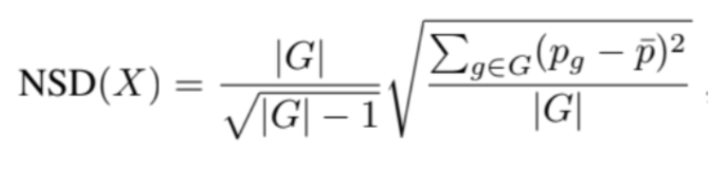



> Formula

    |G| = total number of races

    p(each race) = n( race = each ) / n(race = all )

    Summation [ p(race = each) - mean(p(races))^2 ]

In [ ]:
def NSD(df, races):
    G=0
    races_df=[]
    p_values=[]
    ct_race=0
    ct_all=0

    for index, row in df.iterrows():
        if(row['gt_race'] not in races_df):
            races_df.append(row['gt_race'])
    G=len(races_df)

    for race1 in races_df:
        for index, row in df.iterrows():
            if(row['gt_race']==race1):
                ct_race+=1
            ct_all+=1
        p=ct_race/ct_all
        p_values.append(p)
    p_mean= sum(p_values) / len(p_values)

    term1 = 0
    term1 = G / math.sqrt(G-1)

    term2 = 0
    for p in p_values:
        term2 = (p - p_mean)*(p - p_mean)
    term3 = term2/G

    return term1*math.sqrt(term3)

In [ ]:
NSD(result_non_dann_expw, set(result_non_dann_expw['gt_race']))

0.009477943836674196

In [ ]:
NSD(result_non_dann, set(result_non_dann['gt_race']))

0.29430297552154655

Imbalance Ratio(IR)

> Formula

```
max ( n(each race) ) / min ( n(each race) )

```


In [ ]:
def ImbalanceRatio(df, races):
    races_list=[]
    races_dict={}
    i=0
    for index, row in df.iterrows():
        races_dict[row['gt_race']]=0

    for index, row in df.iterrows():
        races_dict[row['gt_race']]+=1

    return max(races_dict.values())/min(races_dict.values())

In [ ]:
ImbalanceRatio(result_non_dann_expw, set(result_non_dann_expw['gt_race']))

28.59605911330049

In [ ]:
ImbalanceRatio(result_non_dann, set(result_non_dann['gt_race']))

412.0

### Peeyush Sir code

In [ ]:
source= 'sfew'
target = 'expw'

col_name = ['model_class','trained_on','accuracy_source','accuracy_target']
df_nice_results = pd.DataFrame(columns = col_name)
print(df_nice_results)
dict_input = {}
dict_input = {'model_class': 'Non_DANN',
                   'trained_on': str(source)+ " source",
                #    'accuracy_source':dict_non_dann_losses_list_sfew_expw['test_accuracy_source'],
                #    'accuracy_target':dict_non_dann_losses_list_sfew_expw['test_accuracy_target'],
                   'accuracy_source':non_dann_accuracy_source,
                   'accuracy_target':non_dann_accuracy_target
                   }
print(dict_input)
df_nice_results = pd.concat([df_nice_results, pd.DataFrame(dict_input, index=[0])], ignore_index=True)


dict_input = {'model_class': 'DANN',
                   'trained_on': str(source)+" source + "+str(target) + " target",
                  #  'accuracy_source':dict_dann_losses_list_sfew_expw['test_accuracy_source'],
                  #  'accuracy_target':dict_dann_losses_list_sfew_expw['test_accuracy_target'],
                   'accuracy_source':dann_accuracy_source,
                   'accuracy_target':dann_accuracy_target
                   }
print(dict_input)

df_nice_results = pd.concat([df_nice_results, pd.DataFrame(dict_input, index=[0])], ignore_index=True)


dict_input = {'model_class': 'EWC_DANN',
                   'trained_on': str(source)+" source + "+str(target) + " target",
                  #  'accuracy_source':dict_ewc_dann_losses_list_sfew_expw['test_accuracy_source'],
                  #  'accuracy_target':dict_ewc_dann_losses_list_sfew_expw['test_accuracy_target'],
                   'accuracy_source':ewc_dann_accuracy_source,
                   'accuracy_target':ewc_dann_accuracy_target
                   }

df_nice_results = pd.concat([df_nice_results, pd.DataFrame(dict_input, index=[0])], ignore_index=True)


df_nice_results

Empty DataFrame
Columns: [model_class, trained_on, accuracy_source, accuracy_target]
Index: []
{'model_class': 'Non_DANN', 'trained_on': 'sfew source', 'accuracy_source': 22.01834862385321, 'accuracy_target': 15.205580029368576}
{'model_class': 'DANN', 'trained_on': 'sfew source + expw target', 'accuracy_source': 23.853211009174313, 'accuracy_target': 15.697503671071953}


C:\Users\Admin\AppData\Local\Temp\ipykernel_14332\4160264040.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nice_results = pd.concat([df_nice_results, pd.DataFrame(dict_input, index=[0])], ignore_index=True)


,model_class,trained_on,accuracy_source,accuracy_target
0,Non_DANN,sfew source,22.018349,15.205580
1,DANN,sfew source + expw target,23.853211,15.697504
2,EWC_DANN,sfew source + expw target,23.394495,16.563877


### Bias Evaluation